A lot of this stuff hinges on having the right initial data. We cant run the agents at this moment. I Added the stuff here that was already in workshop 4, but like I said, it will not run.

Personally, I believe that we have to store the eventual data of every script in a csv file. This script needs a program of requirements.

Load Libraries

In [99]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import pandas as pd
import numpy as np
import functions
np.random.seed(0)

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

Define Stencil

In [100]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


Define the environment

In [101]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)


load program (insert the program of requirements here)

In [102]:
#loading the relative relations excell

# relative_rels = pd.read_excel('../data/relationships/relative_relations.xlsx', index_col=0) 
# relative_rels_norm = relative_rels.div(relative_rels.sum(axis=1), axis=0)
# relative_rels_norm = relative_rels_norm.fillna(0)

#loading the relative preferences excell
relative_prefs = pd.read_excel('../data/relationships/relative_preferences.xlsx')
relative_prefs.iloc[:, 1:] = relative_prefs.iloc[:, 1:].div(relative_prefs.iloc[:, 1:].sum(axis=1), axis=0)
relative_prefs.iloc[:, 1:] = relative_prefs.iloc[:, 1:].fillna(0)
relative_prefs_norm = relative_prefs
relative_prefs_norm = relative_prefs_norm.head(3)

In [103]:
program_prefs = relative_prefs_norm.drop(["space_name", "facade_connection","penthouse_factor","street_sight", "noise_approval", "sunlight_access", "sky_view_factor", "football_field"], 1)
program_prefs

,proximity_to_ground_floor
0,0.000000
1,0.000000
2,0.181818


Load the value fields

In [104]:
# loading the lattice from csv
fields = {}
for f in program_prefs.columns:
    lattice_path = os.path.relpath('../data/fields/' + f + '.csv')
    fields[f] = tg.lattice_from_csv(lattice_path)

Initialize the agents

In [105]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1

# Finding the index of the available voxels in avail_lattice
avail_flat = avail_lattice.flatten()
avail_index = np.array(np.where(avail_lattice == 1)).T

# Randomly choosing three available voxels
agn_num = len(program_prefs)
np.random.seed()
select_id = np.random.choice(len(avail_index), agn_num)
agn_origins = avail_index[select_id]

# adding the origins to the agents locations
agn_locs = []
# for each agent origin ... 
for a_id, a_origin in enumerate(agn_origins):

    # add the origin to the list of agent locations
    agn_locs.append([a_origin])

    # set the origin in availablity lattice as 0 (UNavailable)
    avail_lattice[tuple(a_origin)] = 0

    # set the origin in occupation lattice as the agent id (a_id)
    occ_lattice[tuple(a_origin)] = a_id

printing the ammount of agents

In [106]:
print(a_id)

2


show the agents

In [107]:
p = pv.Plotter(notebook=True)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(occ_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = occ_lattice.minbound - occ_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = occ_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#777777")

# Add the data values to the cell data
grid.cell_arrays["Agents"] = occ_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, show_edges=True, opacity=1.0, show_scalar_bar=False)

# adding the availability lattice
init_avail_lattice.fast_vis(p)

p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

Run the simulation

In [108]:
# make a deep copy of occupation lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0
n_frames = 30
# main feedback loop of the simulation (for each time step ...)
while t<n_frames:
    # for each agent ... 
    for a_id, a_prefs in relative_prefs_norm.iterrows():
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]:
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id)
        # check if found any free neighbour
        if len(free_neighs)>0:
            # convert free neighbours to a numpy array
            fns = np.array(free_neighs)

            # find the value of neighbours
            # init the agent value array
            a_eval = np.ones(len(fns))
            # for each field...
            for f in program_prefs.columns:
                # find the raw value of free neighbours...
                vals = fields[f][fns[:,0], fns[:,1], fns[:,2]]
                # raise the the raw value to the power of preference weight of the agent
                a_weighted_vals = vals ** a_prefs[f]
                # multiply them to the previous weighted values
                a_eval *= a_weighted_vals

            #post-processing
            functions.squareness(square_weight=0.9, free_neighs=free_neighs, a_eval=a_eval)


            # select the neighbour with highest evaluation
            selected_int = np.argmax(a_eval)
            # find 3D integer index of selected neighbour
            selected_neigh_3d_id = free_neighs[selected_int]
            # find the location of the newly selected neighbour
            selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()
            # add the newly selected neighbour location to agent locations
            agn_locs[a_id].append(selected_neigh_loc)
            # set the newly selected neighbour as UNavailable (0) in the availability lattice
            avail_lattice[selected_neigh_3d_id] = 0
            # set the newly selected neighbour as OCCUPIED by current agent 
            # (-1 means not-occupied so a_id)
            occ_lattice[selected_neigh_3d_id] = a_id

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice)
    # adding one to the time counter
    t += 1

Visualize the result

In [109]:
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, agn_num - 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)

    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

### Collecting Agent voxels and creating a mesh out of them

In [110]:
# duplicating the ocuupied lattice from the agent growth process
occupied_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)
# setting the values of the occupied lattice to 0
occupied_lattice[occupied_lattice==1]=0

# retrieving the agent locations
for i in range(len(agn_locs)):
    for loc in agn_locs[i]:
        occupied_lattice[tuple(loc)]=1


# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
occupied_lattice.fast_vis(p)

#p.add_mesh(tri_to_pv(combine_tractor), color='#FAE31D')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

In [111]:
# create a transformation matrix for each agent location 
def transformation_matrix (arr):
    return [[1,0,0,int(arr[0])],[0,1,0,int(arr[1])],[0,0,1,int(arr[2])],[0,0,0,1]]



# collecting center points of agent voxels
agn_cens = occupied_lattice.centroids_threshold(0)

# creating a box mesh and transforming it to each centroid of the agent voxels with the transformation matrix above
meshes = [tm.creation.box(extents=avail_lattice.unit,transform=transformation_matrix(agn_cens[i])) for i in range(len(agn_cens))]
agent_mesh = tm.util.concatenate(meshes)


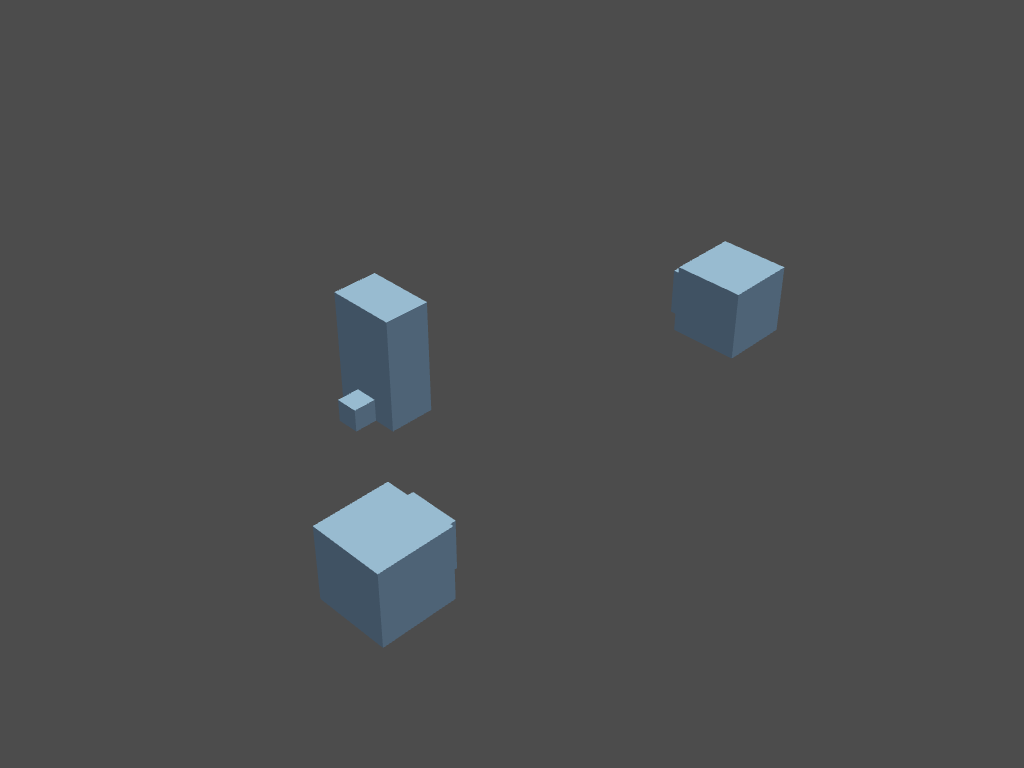

[(177.24923591163108, 104.74923591163108, 169.74923591163108),
 (22.5, -50.0, 15.0),
 (0.0, 0.0, 1.0)]

In [112]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# env_cens.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(agent_mesh), color='#abd8ff')

# plotting
p.show()

### Collecting facade voxels and their centroids

In [113]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
stencil.set_index([0,0,1], 0)
stencil.set_index([0,0,-1], 0)
stencil.function = tg.sfunc.sum
print(stencil)


[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [0 0 0]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


In [114]:
# collecting neighbours count for occupied lattice
occupied_lat_sten=occupied_lattice.apply_stencil(stencil)

facade_lattice=avail_lattice*0
# seperating the voxels with neighbours and excluding the occupied agents to retain only facade voxels
facade_lattice[occupied_lat_sten>0]=1
facade_lattice[occupied_lattice==1]=0

# collecting center points of facade voxels
fcd_cens = facade_lattice.centroids_threshold(0)

In [115]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the facade lattice
facade_lattice.fast_vis(p)

# fast visualization of the facade points
fcd_cens.fast_vis(p)

p.add_mesh(tri_to_pv(agent_mesh), color='#FAE31D')

# plotting
p.show(use_ipyvtk=True)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(239.8279062084888, 147.3279062084888, 222.3279062084888),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]

### adding context mesh and street grid points

In [116]:
# inputting the street grid
# street_grid = os.path.relpath("../data/meshes/grid_points_2022.csv")
# street_g = tg.cloud_from_csv(street_grid)

street_grid_full = os.path.relpath("../data/meshes/grid_points_2022_full.csv")
street_g = tg.cloud_from_csv(street_grid_full)


# inputting the surrounding buildings meshes
context_path = os.path.relpath('../data/meshes/immediate_context.obj')
context_mesh = tm.load(context_path)

# combining the surrounding building meshes with the agent meshes
context_mesh_complete=context_mesh+agent_mesh

### Putting it all together in a single visualization

In [117]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the street grid points
street_g.fast_vis(p)

# facade voxels
facade_lattice.fast_vis(p)

# facade centroids
fcd_cens.fast_vis(p)

# (these aren't the centroids you're looking for)
# not_fcd_cens.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh_complete), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.8088446466429, 708.392439646643, 742.1697567966429),
 (65.08283250000001, -12.333572500000002, 21.44374465),
 (0.0, 0.0, 1.0)]

### extracting vector between facade centroid and street points

In [118]:
# Extracting the vector between the facade centroid and the street points. 
ray_dir=[]
run_count=0
for i in range(len(fcd_cens)):
    for f in range(len(street_g)):
        ray_dir1=street_g[f]-fcd_cens[i]
        ray_dir.append(ray_dir1)
        run_count+=1
ray_dir=np.array(ray_dir)
print(run_count)


41454


### Normalizationa and filtration of clear from the start uninteresting ray directions

In [119]:
# This si the normalization for the ray filter

# ray_dir_norm=[]
# for i in range(len(ray_dir)):
#     ray_dir_norm1 = ray_dir[i]/np.linalg.norm(ray_dir[i])
#     ray_dir_norm.append(ray_dir_norm1)
# ray_d_norm=np.array(ray_dir_norm)
# deg = 20
# rad = deg * 180/np.pi
# threshold=np.cos(rad)

In [120]:
# this is the ray filter before the intersection

# n_z_axis=[0,0,-1]
# dot_product_ray=ray_dirs @ n_z_axis

# valid_ray=[]
# valid_ray_orig_id=[]
# for i in range(len(dot_product_ray)):
#     if dot_product_ray[i] < abs(np.cos(np.pi/9)):
#         valid_ray.append(ray_dirs[i])
#         orig_id=np.where(dot_product_ray[i])
#         valid_ray_orig_id.append(orig_id)
# #valid_ray contins the ray_dirs that have a valid dot product value
# #valid_ray_orig_id contains the np.where(dot_product_ray) of the valid rays
# # so that the id the ray can be traced back to the original configuration    

# v_ray_dirs=np.array(valid_ray)
# valid_ray_orig_id=np.array(valid_ray_orig_id)

### sky_view scrpit

In [121]:
# all the ray origins for each sky directions (vectorization format)
ray_srcs = np.tile(fcd_cens, [1, len(street_g)]).reshape(-1, 3)

# all the ray directions for each centroid
ray_dirs = np.tile(street_g, [len(fcd_cens), 1])

print(len(ray_dirs))
print(len(ray_srcs))

41454
41454


In [122]:
# computing the intersections of rays with the context mesh
tri_id, ray_id = context_mesh.ray.intersects_id(ray_origins=ray_srcs, ray_directions=ray_dir, multiple_hits=False)

### intersection post process

In [123]:
# initialize the 'hits' array with 0
hits = np.array([0] * len(ray_dirs))
# rays that hit the context mesh are set to 1
hits[ray_id] = 1

good_ray=[]
for i in range(len(hits)):
    if hits[i]==0:
        good_ray.append(ray_dir[i])
good_ray=np.array(good_ray)
print(good_ray)
# reshape the 'hits' array to (len(centroids), len(directions))
hits = hits.reshape(len(facade_lattice.centroids), -1)

# sum up all the intersections per centroid
vox_hits = np.sum(hits, axis=1)
print(vox_hits)
no_hit=len(street_g)-vox_hits
print(no_hit)


[[ -34.  -72.  -10.]
 [ -34.  -52.  -10.]
 [ -34.  -42.  -10.]
 ...
 [  51. -102.  -25.]
 [  51.  -92.  -25.]
 [  51.   48.  -25.]]
[37 44 43 49 50 46 49 49 46 53 49 39 46 49 47 49 45 42 53 56 54 56 51 48
 54 59 60 63 55 52 57 62 55 61 64 58 64 63 16 52 58 61 58 14 50 59 62 60
 14 51 60 61 60 19 52 59 59 59 17 52 65 66 66 20 53 61 61 61 18 50 62 64
 63 18 51 60 63 59 47 59 61 60 17 48 61 62 63 17 64 68 59 64 65 68 73 68
 59 66 70 61 64 69 64 70 73 60 64 67 62 70 72 58 62 65 61 69 71 56 61 65
 51 57 62 53 61 64]
[292 285 286 280 279 283 280 280 283 276 280 290 283 280 282 280 284 287
 276 273 275 273 278 281 275 270 269 266 274 277 272 267 274 268 265 271
 265 266 313 277 271 268 271 315 279 270 267 269 315 278 269 268 269 310
 277 270 270 270 312 277 264 263 263 309 276 268 268 268 311 279 267 265
 266 311 278 269 266 270 282 270 268 269 312 281 268 267 266 312 265 261
 270 265 264 261 256 261 270 263 259 268 265 260 265 259 256 269 265 262
 267 259 257 271 267 264 268 260 258 273 268 

### Cross product of the visible street points and the z axis

In [161]:
# this is the order of operations
# take negative z unit vector and the direction ray
z_n=[0,0,-1]
ray=[-0.364,0,-1]

# normalize the direction ray so that the length won't distort the angle analysis
# the length will be stored and dealt seperatly
norms_ray=np.linalg.norm(ray)
normalized=ray/norms_ray

# angle in degrees for a sanity check
angle=(180/np.pi)*np.arccos(np.dot(z_n,normalized))

# taking the cross product of the direction ray and the negative unit z vector
crossed=np.cross(normalized,z_n)

#getting the area between the direction ray and the negative unit z vector
area_p=np.linalg.norm(crossed)

#print(norms_ray)
#print(normalized)
#print(angle)
#print(crossed)
print(area_p)


# condensed this is what happens
ray2=[4,0,3]
z_n=z_n
angle2=(180/np.pi)*np.arccos(np.dot(z_n,(ray2/np.linalg.norm(ray2))))
area_p2=np.linalg.norm(np.cross((ray2/np.linalg.norm(ray2)),z_n))

#print(angle2)
#print(area_p2)

0.34204484166826987


In [125]:
z_n=[0,0,-1]

angle_deg=[]
area_cross=[]
ray_len=[]
for i in range(len(good_ray)):
    ray2=good_ray[i]
    ray_l=np.linalg.norm(ray2)
    angle2=(180/np.pi)*np.arccos(np.dot(z_n,(ray2/ray_l)))
    area_p2=np.linalg.norm(np.cross((ray2/np.linalg.norm(ray2)),z_n))
    angle_deg.append(angle2)
    area_cross.append(area_p2)
    ray_len.append(ray_l)


area_cross2=area_cross
angle_deg2=angle_deg
angle_deg=np.array(angle_deg)
area_cross=np.array(area_cross)
ray_len=np.array(ray_len)
print(angle_deg)
print(area_cross)
print(ray_len)

[82.84169656 80.85634056 79.51555194 ... 77.63508747 76.63086047
 70.35542857]
[0.99220565 0.987293   0.98330434 ... 0.9768036  0.97290056 0.94179621]
[ 80.24961059  62.92853089  54.95452666 ... 116.74759098 108.12030337
  74.36396977]


In [159]:
g=342
print(good_ray[g])
print(angle_deg[g])
print(ray_len[g])
print(area_cross[g])



[ -4.  -2. -15.]
16.601549599020245
15.652475842498529
0.28571428571428575


In [158]:
angle_deg[angle_deg<20]
angle_id=[]
for i in range(len(angle_deg)):
   if angle_deg[i]<20:
       angle_id.append(i)
print(angle_id)

[342, 913, 1193, 1208, 1755, 2035, 2050, 2600, 2876, 2891, 3169, 3458, 3740, 4029, 4311, 4590, 5152, 5427, 5436, 5983, 6257, 6267, 6534, 6815, 7088, 7363, 7632, 7901, 8443, 8714, 8723, 9256, 9523, 9532, 10061, 10325, 10334, 10947, 11220, 11490, 11760, 11761, 12352, 12625, 12893, 12894, 13162, 13163, 13751, 14024, 14293, 14563, 14564, 15415, 15684, 15697, 15953, 15954, 15967, 16815, 17078, 17091, 17341, 17342, 17355, 17930, 18201, 18467, 18468, 18735, 18736, 19329, 19599, 19864, 19865, 20130, 20131, 20984, 21252, 21263, 21519, 21520, 21530, 22073, 22342, 22353, 22610, 22611, 22622, 23473, 23740, 23751, 24008, 24009, 24019, 24618, 24879, 24893, 25149, 25415, 25429, 25691, 25951, 25952, 26210, 26211, 26471, 26472, 26739, 27004, 27265, 27266, 27527, 27792, 27806, 28053, 28054, 28068, 28319, 28579, 28593, 28836, 28837, 28851, 29114, 29380, 29381, 29642, 29643, 29910, 30171, 30172, 30428, 30429, 30693, 30962, 30976, 31225, 31226, 31240, 31495, 31758, 31772, 32015, 32016, 32030, 32297, 32567,

In [129]:
# z_n=[0,0,-1]
# ray_length=[]
# for i in range(len(good_ray)):
#     n_ray=np.linalg.norm(good_ray[i])
#     ray_length.append(n_ray)

# ray_c=[]
# for i in range(len(good_ray)):
#     cross=np.cross(good_ray[i]/ray_length[i],z_n)
#     ray_c.append(cross)

# ray_cross=[]
# for i in range(len(good_ray)):
#     r_cross=np.linalg.norm(ray_c[i])
#     ray_cross.append(r_cross)


# ray_cross=np.array(ray_cross)

# angle=np.arccos(np.dot(z_n,))



In [130]:
# g=15
# print(ray_cross[g])
# print(ray_dir[g])


In [131]:
# flatten the facade_lattice to retrieve the 1 dimensional lattice id
facade_lattice_flat=facade_lattice.flatten()
# retrieving 
fcd_id=np.array(np.argwhere(facade_lattice_flat==1))
for i in range(len(fcd_id)):
    facade_lattice_flat[fcd_id[i]]=no_hit[i]
    

In [132]:
vector=[5,4,3]

magnitude = np.linalg.norm(vector)

print(magnitude)

7.0710678118654755


In [133]:
facade_streetview = facade_lattice_flat.reshape(facade_lattice.shape)

In [134]:
facade_streetview_lat= tg.to_lattice(facade_streetview, facade_lattice)

In [135]:
np.array(np.where(facade_lattice == 1)).T

array([[ 0, 10,  2],
       [ 0, 10,  3],
       [ 0, 11,  2],
       [ 0, 11,  3],
       [ 0, 11,  4],
       [ 0, 12,  2],
       [ 0, 12,  3],
       [ 0, 12,  4],
       [ 0, 13,  2],
       [ 0, 13,  3],
       [ 0, 13,  4],
       [ 1,  9,  2],
       [ 1,  9,  3],
       [ 1, 10,  4],
       [ 1, 14,  2],
       [ 1, 14,  3],
       [ 1, 14,  4],
       [ 2,  9,  2],
       [ 2,  9,  3],
       [ 2, 10,  4],
       [ 2, 14,  2],
       [ 2, 14,  3],
       [ 2, 14,  4],
       [ 3, 10,  2],
       [ 3, 10,  3],
       [ 3, 10,  4],
       [ 3, 14,  2],
       [ 3, 14,  3],
       [ 3, 14,  4],
       [ 4, 11,  2],
       [ 4, 11,  3],
       [ 4, 11,  4],
       [ 4, 12,  2],
       [ 4, 12,  3],
       [ 4, 12,  4],
       [ 4, 13,  2],
       [ 4, 13,  3],
       [ 4, 13,  4],
       [13,  4,  1],
       [13,  4,  2],
       [13,  4,  3],
       [13,  4,  4],
       [13,  4,  5],
       [13,  5,  1],
       [13,  5,  2],
       [13,  5,  3],
       [13,  5,  4],
       [13,  

In [136]:
print(facade_lattice[9,5,6])
print(facade_streetview_lat[9,5,6])


0
0


In [139]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = facade_streetview_lat

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sreet visibilw points"] = l.flatten(order="F")  # Flatten the Lattice

p.add_mesh(tri_to_pv(agent_mesh), color='#aaaaaa')

# adding the volume
opacity = np.array([0,1,1,1,1,1,1])*1.5

p.add_volume(grid, cmap="RdYlBu", clim=[no_hit.min(), no_hit.max()],opacity=opacity, shade=True)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(231.22009113429812, 138.72009113429812, 213.72009113429812),
 (35.0, -57.5, 17.5),
 (0.0, 0.0, 1.0)]